Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\Kesler\anaconda3\envs\assimulo\Lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


Key Enhanced Green Fluorescent Protein not found in the registry.
Returning default values: {'k_app': 5000.0, 'k1': 0.786, 'k2': 60400000.0} for keys: ['Enhanced Green Fluorescent Protein', 'lhs']
Initial conditions: {'RNA [M]': 0.0, 'PPi [M]': 0.0, 'Pi [M]': 1e-12, 'ATP [M]': 0.013, 'CTP [M]': 0.013, 'GTP [M]': 0.013, 'UTP [M]': 0.013, 'H+ [M]': 0.04062245884424016, 'Mg2+ [M]': 0.079, 'DNA [µg/mL]': 27.0, 'T7RNAP [units/uL]': 342.0, 'PPi (solid) [M]': 1e-12, 'dsRNA [M]': 1e-12, 'HEPES [mM]': 0.05, 'Acetate [mM]': 0.042, 'Spd [M]': 1e-12, 'H+ (free) [M]': 1.9952623149688787e-07, 'Mg2+ (free) [M]': 0.0, 'MgATP [M]': 0.0, 'MgCTP [M]': 0.0, 'MgGTP [M]': 0.0, 'MgUTP [M]': 0.0, 'HEP [M]': 0.009854541492309216, 'HHEP [M]': 0.04014545850769079, 'Ac [M]': 0.04152324930929219, 'HAc [M]': 0.00047675069070781534}
Kinetic parameters: {'k_app': 5000.0, 'k1': 0.786, 'k2': 60400000.0, 'k_PPase': 3120.0, 'k_prec': 500.0, 'k_d': 0, 'k_ds': 0, 'init_seq_len': 8, 'init_rate_nt_s': 0.5, 'elong_rate_nt_s':

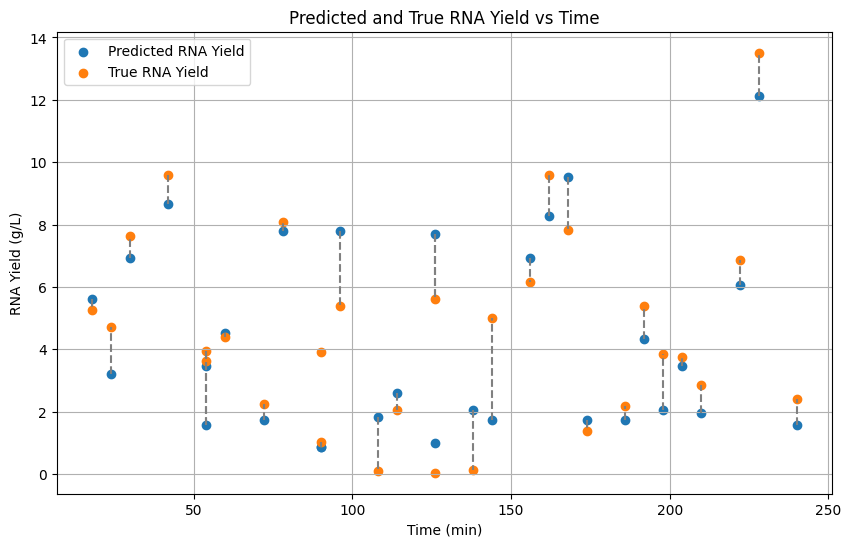

In [1]:
import r3.schema as schema
import r3.adapters as adapters
from matplotlib import pyplot as plt
import r3.models.assimulo.assimulo_model as ivt_model
from sklearn.metrics import r2_score
import numpy as np

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.Spd_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]
experimental_conditions, response = adapters.DataPipelineAdapter(
    "egfp_lhs", verbose=False
).get(X_columns=X_columns, y_columns=y_columns)

model = ivt_model.AssimuloIVTModel(template=schema.DNATemplates.eGFP)
predictions = model.predict_rna_yield(
    experimental_conditions=experimental_conditions,
    verbose=True,
)

print("Predictions")
print(predictions)
print("Actual Response")
print(response)

print(
    r2_score(
        response[schema.IVTReactionSchema.RNA_g_L.value],
        predictions[schema.IVTReactionSchema.RNA_g_L.value],
    )
)

# show root mean squared error
rmse = np.sqrt(
    np.mean(
        (
            response[schema.IVTReactionSchema.RNA_g_L.value]
            - predictions[schema.IVTReactionSchema.RNA_g_L.value]
        )
        ** 2
    )
)
print(f"RMSE: {rmse:.4f} g/L")

plt.figure(figsize=(10, 6))
plt.scatter(
    experimental_conditions[schema.IVTReactionSchema.TIME_min.value],
    predictions[schema.IVTReactionSchema.RNA_g_L.value],
    marker="o",
    label="Predicted RNA Yield",
)
ax = plt.gca()
for i in experimental_conditions[schema.IVTReactionSchema.TIME_min.value]:
    ax.vlines(
        i,
        predictions.loc[
            experimental_conditions[schema.IVTReactionSchema.TIME_min.value] == i,
            schema.IVTReactionSchema.RNA_g_L.value,
        ].values[0],
        response.loc[
            experimental_conditions[schema.IVTReactionSchema.TIME_min.value] == i,
            schema.IVTReactionSchema.RNA_g_L.value,
        ].values[0],
        color="gray",
        linestyle="--",
    )

plt.scatter(
    experimental_conditions[schema.IVTReactionSchema.TIME_min.value],
    response[schema.IVTReactionSchema.RNA_g_L.value],
    marker="o",
    label="True RNA Yield",
)
plt.xlabel("Time (min)")
plt.ylabel("RNA Yield (g/L)")
plt.title("Predicted and True RNA Yield vs Time")
plt.legend()
plt.grid()
plt.show()